# YOLO Segmentation with Webcam Demo

This notebook demonstrates how to use YOLO segmentation with frames captured from a webcam.

In [ ]:
# Install required packages if not already installed
import sys
import subprocess

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Check if ultralytics is installed
try:
    import ultralytics
except ImportError:
    print("Installing ultralytics...")
    install_package("ultralytics")

print("Required packages are installed.")

In [3]:
# Import required libraries
import cv2
import numpy as np
import torch
from ultralytics import YOLO
import time
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# Add src to path to import our custom YOLO segmentation class
import sys
from pathlib import Path
sys.path.append(str(Path().resolve()))

from yolo_segmentation import YOLOSegmentation

print("Libraries imported successfully.")

Libraries imported successfully.


In [4]:
# Initialize YOLO segmentation
yolo_seg = YOLOSegmentation("yolov8n-seg.pt")  # Using nano model for speed

# Load model
if not yolo_seg.load_model():
    print("Failed to load YOLO model")
else:
    print("YOLO model loaded successfully!")

Loading YOLO segmentation model: yolov8n-seg.pt
Using device: mps
YOLO segmentation model loaded successfully!
YOLO model loaded successfully!


In [5]:
# Function to capture a single frame from webcam
def capture_frame(webcam_id=0):
    """
    Capture a single frame from the webcam.
    
    Args:
        webcam_id (int): ID of the webcam to use (default: 0)
        
    Returns:
        np.ndarray: Captured frame, or None if failed
    """
    cap = cv2.VideoCapture(webcam_id)
    
    if not cap.isOpened():
        print(f"Cannot open webcam {webcam_id}")
        return None
    
    # Set resolution (optional)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    # Capture frame
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print("Failed to capture frame")
        return None
    
    return frame

Capturing frame from webcam...
Frame captured successfully. Performing segmentation...
Segmentation completed in 1.26 seconds


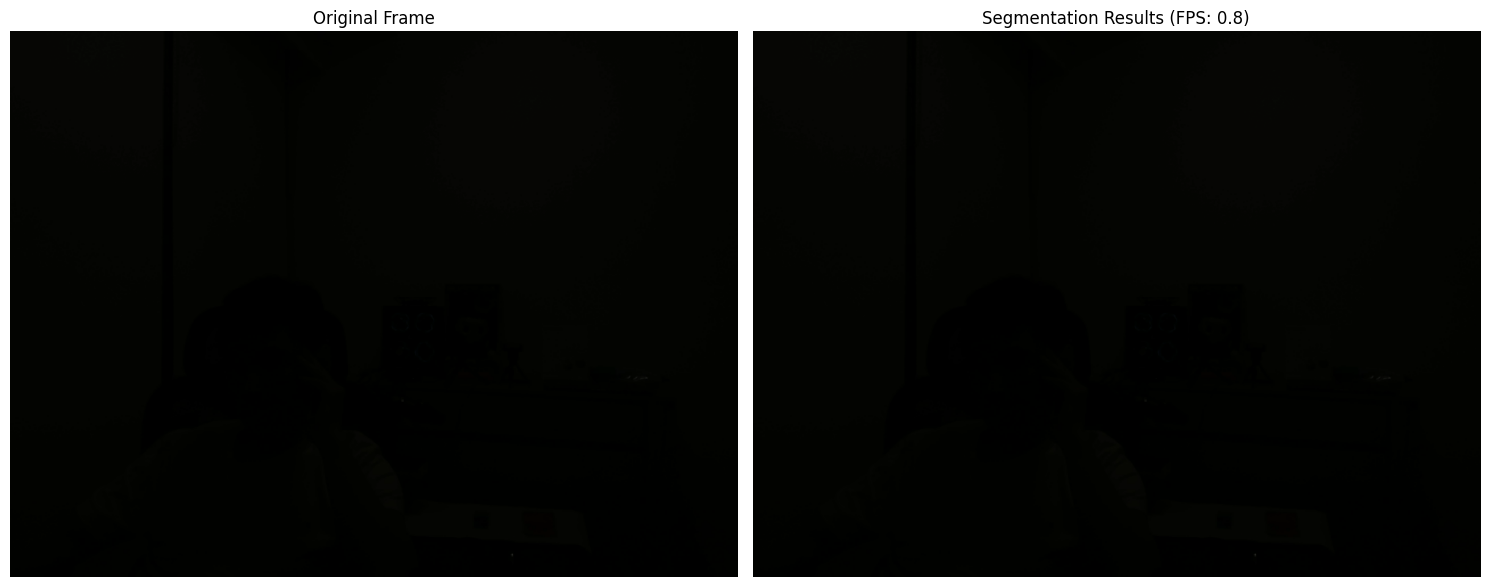

No objects detected.


In [6]:
# Capture a frame and perform segmentation
print("Capturing frame from webcam...")
frame = capture_frame()

if frame is not None:
    print("Frame captured successfully. Performing segmentation...")
    
    # Perform segmentation
    start_time = time.time()
    result = yolo_seg.segment_frame(frame)
    inference_time = time.time() - start_time
    
    if result is not None:
        print(f"Segmentation completed in {inference_time:.2f} seconds")
        
        # Visualize results
        vis_frame = yolo_seg.visualize_segmentation(frame, result)
        
        # Convert BGR to RGB for matplotlib
        vis_frame_rgb = cv2.cvtColor(vis_frame, cv2.COLOR_BGR2RGB)
        original_frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Display results
        fig, axes = plt.subplots(1, 2, figsize=(15, 8))
        
        axes[0].imshow(original_frame_rgb)
        axes[0].set_title("Original Frame")
        axes[0].axis('off')
        
        axes[1].imshow(vis_frame_rgb)
        axes[1].set_title(f"Segmentation Results (FPS: {1/inference_time:.1f})")
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print detected objects
        if len(result["boxes"]) > 0:
            print("\nDetected objects:")
            for i in range(len(result["boxes"])):
                box = result["boxes"][i]
                score = result["scores"][i]
                cls = int(result["classes"][i])
                label = result["names"].get(cls, f"Class {cls}")
                print(f"  - {label}: {score:.2f} (bbox: [{box[0]:.1f}, {box[1]:.1f}, {box[2]:.1f}, {box[3]:.1f}])")
        else:
            print("No objects detected.")
    else:
        print("Segmentation failed.")
else:
    print("Failed to capture frame from webcam.")

In [ ]:
# Advanced example: Extract masks for specific classes
if frame is not None and result is not None:
    # Get class names
    class_names = result["names"]
    print("Available classes:")
    for class_id, class_name in class_names.items():
        print(f"  {class_id}: {class_name}")
    
    # Example: Extract masks for person class (class ID 0 in COCO dataset)
    person_mask = yolo_seg.get_class_masks(result, 0)  # 0 is person class in COCO
    
    if person_mask is not None:
        # Display the person mask
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title("Original Frame")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(person_mask, cmap='gray')
        plt.title("Person Mask")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print("Person mask extracted successfully.")
    else:
        print("No persons detected in the frame.")

## Real-time Webcam Segmentation

The following cell will start a real-time segmentation demo. Press the stop button (⏹️) in Jupyter to stop the demo.

In [ ]:
# Real-time webcam segmentation demo
# Note: This will run continuously until stopped manually

print("Starting real-time webcam segmentation demo...")
print("Press the stop button (⏹️) in Jupyter to stop the demo.")

# Open webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Cannot open webcam")
else:
    try:
        while True:
            # Capture frame
            ret, frame = cap.read()
            if not ret:
                print("Failed to capture frame")
                break
            
            # Perform segmentation
            start_time = time.time()
            result = yolo_seg.segment_frame(frame)
            print('The result', result)
            
            inference_time = time.time() - start_time
            
            if result is not None:
                # Visualize results
                vis_frame = yolo_seg.visualize_segmentation(frame, result)
                
                # Add FPS counter
                fps = 1.0 / inference_time if inference_time > 0 else 0
                cv2.putText(vis_frame, f"FPS: {fps:.1f}", (10, 30),
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                
                # Convert to RGB for matplotlib
                vis_frame_rgb = cv2.cvtColor(vis_frame, cv2.COLOR_BGR2RGB)
                
                # Display frame
                clear_output(wait=True)
                plt.figure(figsize=(12, 8))
                plt.imshow(vis_frame_rgb)
                plt.title("Real-time YOLO Segmentation")
                plt.axis('off')
                plt.show()
                
                # Print detection info
                if len(result["boxes"]) > 0:
                    print(f"Detected {len(result['boxes'])} objects (FPS: {fps:.1f}):")
                    for i in range(len(result["boxes"])):
                        score = result["scores"][i]
                        cls = int(result["classes"][i])
                        label = result["names"].get(cls, f"Class {cls}")
                        print(f"  - {label}: {score:.2f}")
                else:
                    print(f"No objects detected (FPS: {fps:.1f})")
            else:
                print("Segmentation failed")
                
    except KeyboardInterrupt:
        print("Demo interrupted by user")
    except Exception as e:
        print(f"Error during demo: {e}")
    finally:
        # Clean up
        cap.release()
        plt.close('all')

## Using Custom YOLO Models

You can also use custom-trained YOLO segmentation models:

In [ ]:
# Example of using a different YOLO model
# Uncomment and modify the path to use a custom model

# custom_yolo_seg = YOLOSegmentation("path/to/your/custom_model.pt")
# if custom_yolo_seg.load_model():
#     frame = capture_frame()
#     if frame is not None:
#         result = custom_yolo_seg.segment_frame(frame)
#         if result is not None:
#             vis_frame = custom_yolo_seg.visualize_segmentation(frame, result)
#             vis_frame_rgb = cv2.cvtColor(vis_frame, cv2.COLOR_BGR2RGB)
#             plt.figure(figsize=(12, 8))
#             plt.imshow(vis_frame_rgb)
#             plt.title("Custom Model Segmentation")
#             plt.axis('off')
#             plt.show()

## Segmentation Anything 2

In [ ]:
import cv2
from ultralytics import SAM
import numpy as np

# 加载SAM模型
model = SAM("sam2.1_b.pt")

# 打开摄像头
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("无法打开摄像头")
    exit()

print("按 'q' 键退出")
print("按 '1' 键：边界框提示")
print("按 '2' 键：单点提示") 
print("按 '3' 键：多点提示")
print("按 '4' 键：负点提示")
print("按 '5' 键：多点提示（嵌套格式）")

# 预设默认值
DEFAULT_BBOX = [100, 100, 300, 300]  # 默认边界框 [x1, y1, x2, y2]
DEFAULT_POINT = [320, 240]  # 默认单点 [x, y]
DEFAULT_MULTI_POINTS = [[200, 180], [400, 300]]  # 默认多点 [[x1,y1], [x2,y2]]
DEFAULT_NEG_POINTS = [[[200, 180], [400, 300]]]  # 默认嵌套格式点
DEFAULT_LABELS = [1, 0]  # 默认标签 [正点, 负点]

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # 显示原始帧
    cv2.imshow('SAM Webcam', frame)
    
    key = '2'
    
    if key == ord('q'):
        break
    elif key == ord('1'):  # 边界框提示
        results = model(frame, bboxes=[DEFAULT_BBOX])
        print("使用默认边界框提示")
    elif key == ord('2'):  # 单点提示
        results = model(frame, points=[DEFAULT_POINT], labels=[1])
        print("使用默认单点提示")
    elif key == ord('3'):  # 多点提示
        results = model(frame, points=DEFAULT_MULTI_POINTS, labels=[1, 1])
        print("使用默认多点提示")
    elif key == ord('4'):  # 负点提示
        results = model(frame, points=DEFAULT_MULTI_POINTS, labels=DEFAULT_LABELS)
        print("使用默认负点提示")
    elif key == ord('5'):  # 多点提示（嵌套格式）
        results = model(frame, points=DEFAULT_NEG_POINTS, labels=[DEFAULT_LABELS])
        print("使用默认嵌套多点提示")
    else:
        continue  # 忽略其他按键
    
    # 处理并显示结果
    if results and len(results) > 0:
        masks = results[0].masks
        if masks is not None:
            mask = masks.data[0].cpu().numpy()
            mask = (mask > 0).astype(np.uint8) * 255
            
            # 创建掩码可视化
            overlay = frame.copy()
            overlay[mask > 0] = [0, 255, 0]  # 绿色掩码
            alpha = 0.5
            result_frame = cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0)
            
            cv2.imshow('SAM Result', result_frame)
            print("推理完成，显示分割结果")
        else:
            print("未检测到有效掩码")

# 释放资源
cap.release()
cv2.destroyAllWindows()


按 'q' 键退出
按 '1' 键：边界框提示
按 '2' 键：单点提示
按 '3' 键：多点提示
按 '4' 键：负点提示
按 '5' 键：多点提示（嵌套格式）


KeyboardInterrupt: 